In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(10)

## Algorytm Greedy Nearest

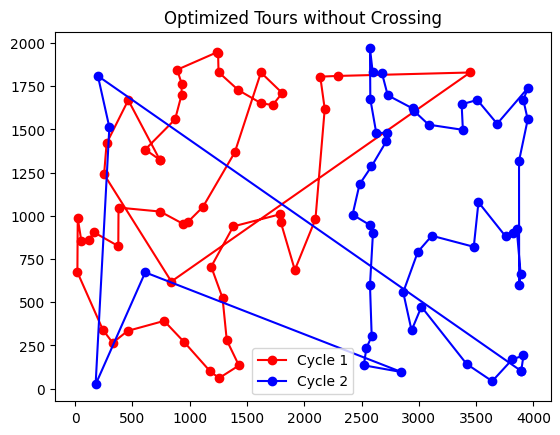

In [6]:


def calculate_distance(city1, city2):
    return np.round(np.linalg.norm(city1 - city2))

def create_alternate_cycles(cities):
    n = cities.shape[0]
    unvisited = list(range(n))
    
    # Randomly choose the starting point for the first cycle
    tour1 = [unvisited.pop(np.random.randint(0, len(unvisited)))]
    start_city_1 = unvisited[tour1[0]]
    
    # Choose the furthest city from the starting point as the initial point for the second cycle
    start_city_2_idx = np.argmax([calculate_distance(cities[tour1[0]], cities[i]) for i in unvisited])
    tour2 = [unvisited.pop(start_city_2_idx)]
    start_city_2 = unvisited[start_city_2_idx]
    
    while unvisited:
        current_city = tour1[-1]

        # Calculate distances to unvisited cities
        distances1 = [calculate_distance(cities[current_city], cities[j]) for j in unvisited]
        closest_city1 = unvisited.pop(np.argmin(distances1))
        tour1.append(closest_city1)

        if unvisited:
            current_city = tour2[-1]

            # Calculate distances to unvisited cities
            distances2 = [calculate_distance(cities[current_city], cities[j]) for j in unvisited]
            closest_city2 = unvisited.pop(np.argmin(distances2))
            tour2.append(closest_city2)

    return tour1, tour2

def plot_optimized_tours(positions, cycle1, cycle2):
    # Ensure the cycles start and end at the same city to form closed loops
    cycle1.append(cycle1[0])
    cycle2.append(cycle2[0])

    # Plot the optimized tours
    plt.plot(positions[cycle1, 0], positions[cycle1, 1], linestyle='-', marker='o', color='r', label='Cycle 1')
    plt.plot(positions[cycle2, 0], positions[cycle2, 1], linestyle='-', marker='o', color='b', label='Cycle 2')

    # Add legend and title
    plt.legend()
    plt.title('Optimized Tours without Crossing')
    plt.show()

# Load data from CSV file
data = pd.read_csv('kroa.csv', sep=' ')
positions = np.array([data['x'], data['y']]).T

# # Add text box with information
# N = data.shape[0]
# total_length_cycle1 = sum(calculate_distance(positions[cycle1[i-1]], positions[cycle1[i]]) for i in range(N))
# total_length_cycle2 = sum(calculate_distance(positions[cycle2[i-1]], positions[cycle2[i]]) for i in range(N))
# textstr = "N nodes: %d\nTotal length cycle 1: %.3f\nTotal length cycle 2: %.3f" % (N, total_length_cycle1, total_length_cycle2)
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes, fontsize=14, verticalalignment='top', bbox=props)


# Create two separate cycles without lines crossing
cycle1, cycle2 = create_alternate_cycles(positions)

# Plot the optimized tours
plot_optimized_tours(positions, cycle1, cycle2)

## Algorytm Greedy

In [7]:
# code

## Algorytm 2-regret

In [8]:
# code